**Cartographie haute résolution du carbone organique du sol (Algérie)**

Enseignant : Dr. Ghiles Kaci

Durée : 2 Hours

Zone d’étude : Tell Atlas, Algeria

**1. Introduction & Objectifs pédagogiques**

**Le défi :**
Global soil maps (like SoilGrids) are excellent, but they are often too coarse (250m resolution) for local agricultural decision-making. Farmers manage land at the scale of meters, not hundreds of meters.

**La solution :**
We can "downscale" these coarse maps by fusing them with high-resolution satellite data. We use the coarse map as a "teacher" (training data) and high-resolution satellites (Landsat, SRTM) as the "predictors" to generate a new, detailed 30m map.

**Objectifs d’apprentissage :**



*   **Access** cloud-native geospatial data (Landsat, SRTM) and local soil data.
*   **Compute** environmental indices (MSAVI, Bare Soil Index) to represent vegetation and soil health.
*   **Engineer** a training dataset by resampling and aligning disparate rasters (Downscaling).
*   **Train** a Random Forest Regressor to predict Soil Organic Carbon (SOC).
*   **Quantify** model uncertainty using an ensemble approach.

**2. Installation et bibliothèques**

We rely on the Pangeo stack—a modern ecosystem of open-source tools for big geospatial data.

1. xarray / rioxarray: For handling multidimensional raster data (labeled arrays).

2. pystac_client: To search satellite catalogs like Google.

3. scikit-learn: For the Random Forest machine learning model.

In [55]:
# Install necessary packages (uncomment if running in Colab/Binder)
!pip install pystac-client planetary-computer rioxarray xarray geopandas rasterio scikit-learn matplotlib

import pystac_client
import planetary_computer
import rioxarray
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# Configure matplotlib for pretty plots
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')

**3. Acquisition des données**

**3.1 Définition de la zone d’étude (AOI)**

To ensure this runs smoothly on your laptops, we will focus on a specific agricultural window in the Tell Atlas region of northern Algeria. We define this using a Bounding Box.

In [56]:
# Define the Area of Interest (Tell Atlas, Algeria)
# Format: [min_lon, min_lat, max_lon, max_lat]
# This covers a roughly 10km x 10km area to ensure fast processing
aoi_bbox = [3.0, 36.4, 3.15, 36.5]

print(f"Study Area Defined: {aoi_bbox}")

Study Area Defined: [3.0, 36.4, 3.15, 36.5]


**3.2 Access the Target Variable (SoilGrids)**

We use **SoilGrids (ISRIC)** as our "Pseudo-Ground-Truth." We are interested in SOC stock (0-5cm).

**Handling Data Access:**
We will load the local file out.tif that contains the SoilGrids data. The code below is robust: it checks both your current folder (if you uploaded it) and your local Windows path.

Success! Found file at: out.tif


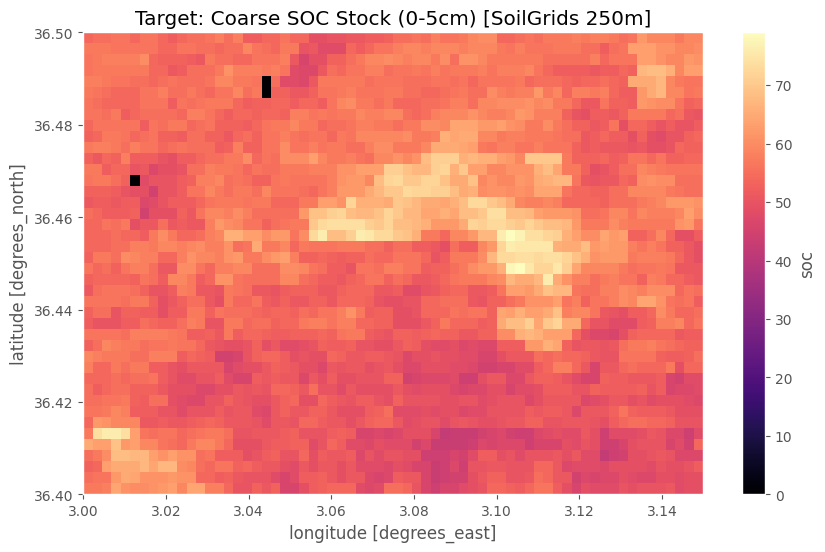

Original SOC Resolution: (0.0022727272727272757, -0.0023809523809525676)


In [57]:
# Define the filename
target_file = "out.tif"

# List of paths to check
# 1. Check the current directory (default for Colab/Cloud uploads)
# 2. Check your specific local Windows path (if running locally)
possible_paths = [
    target_file,
    r"C:\Users\ghile\Downloads\out.tif"
]

local_filepath = None
for path in possible_paths:
    if os.path.exists(path):
        local_filepath = path
        print(f"Success! Found file at: {local_filepath}")
        break

if local_filepath is None:
    # Debugging info if file is missing
    print(f"\nERROR: Could not find '{target_file}' in any of these locations:")
    for p in possible_paths:
        print(f" - {p}")
    print(f"\nCurrent working directory: {os.getcwd()}")
    try:
        print(f"Files available here: {os.listdir()}")
    except:
        pass

    raise FileNotFoundError("Please upload 'out.tif' to this notebook's environment (Files tab on the left).")

# Open the found file
soc_coarse = rioxarray.open_rasterio(local_filepath)

# --- POST-PROCESSING ---
# Clip to AOI (Safety check)
soc_coarse = soc_coarse.rio.clip_box(*aoi_bbox)

# Rename to 'soc' and save to memory
soc_coarse.name = "soc"

# Visualize the "Truth"
soc_coarse.plot(cmap="magma")
plt.title("Target: Coarse SOC Stock (0-5cm) [SoilGrids 250m]")
plt.show()

print("Original SOC Resolution:", soc_coarse.rio.resolution())


**3.3 Access Predictors: Relief (Topography)**

Topography drives water flow and soil accumulation. We use the **NASADEM (SRTM)** at 30m resolution.

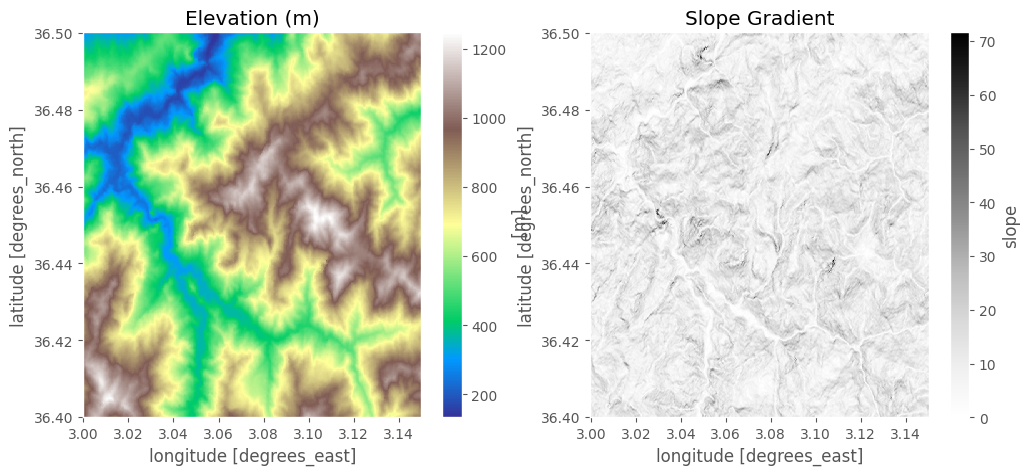

In [58]:
# Connect to Microsoft Planetary Computer STAC Catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Search for Elevation Data
search = catalog.search(
    collections=["nasadem"],
    bbox=aoi_bbox
)
item = next(search.items()) # Get the first available tile

# Load Elevation
elevation = rioxarray.open_rasterio(item.assets["elevation"].href)
elevation = elevation.rio.clip_box(*aoi_bbox)
# Remove the 'band' dimension, as we are typically dealing with a single band for elevation
elevation = elevation.squeeze('band', drop=True)

# Calculate Slope (Simplified numeric gradient)
# In a full production workflow, we would use xarray-spatial for this
# Now elevation.values is 2D, and elevation.coords/dims are 2D
dx, dy = np.gradient(elevation.values)
slope = np.sqrt(dx**2 + dy**2)
slope_da = xr.DataArray(slope, coords=elevation.coords, dims=elevation.dims)
slope_da.name = "slope"

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
elevation.plot(ax=ax1, cmap="terrain")
ax1.set_title("Elevation (m)")
slope_da.plot(ax=ax2, cmap="Greys")
ax2.set_title("Slope Gradient")
plt.show()

**3.3 Access Predictors: Relief (Topography)**

Topography drives water flow and soil accumulation. We use the **NASADEM (SRTM)** at 30m resolution.

Found 52 potential Landsat scenes.
Checking scenes for full coverage...
Selected Scene: LC09_L2SP_196035_20240805_02_T1 | Cloud Cover: 0.0%


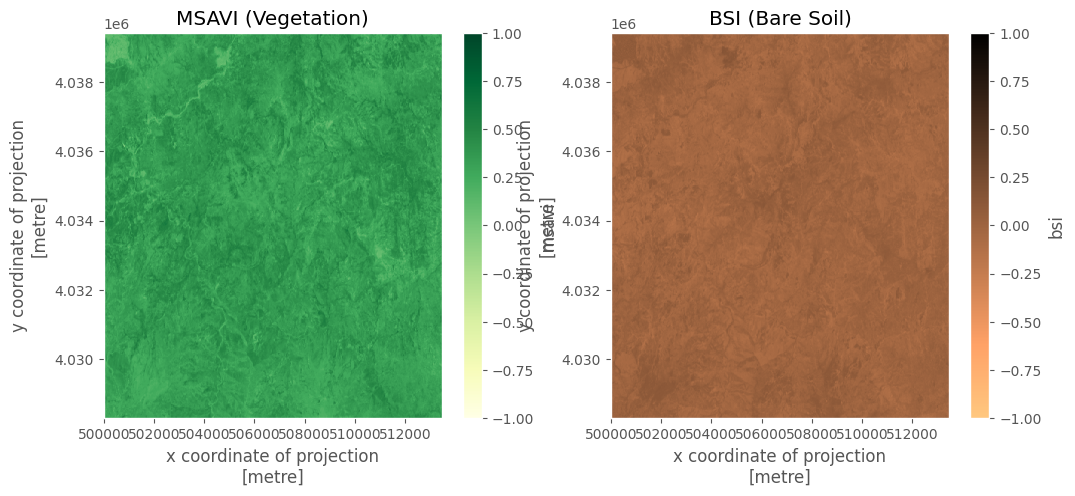

In [59]:
# Search for Landsat Collection 2 Level-2 (Surface Reflectance)
search_landsat = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=aoi_bbox,
    # Broad date range (Spring/Summer 2023-2024) to find good data
    datetime="2023-01-01/2024-12-31",
    query={"eo:cloud_cover": {"lt": 20}} # Relaxed to 20% to ensure we find a scene
)

# Get all found items and sort by cloud cover (least cloudy first)
landsat_items = sorted(list(search_landsat.items()), key=lambda item: item.properties["eo:cloud_cover"])

print(f"Found {len(landsat_items)} potential Landsat scenes.")

if not landsat_items:
    raise ValueError("No Landsat scenes found. Try increasing the cloud cover threshold or broadening the date range.")

# Try to find a scene that covers our AOI completely
selected_item = None
bands = {}
required_bands = ["red", "blue", "nir08", "swir16"]

print("Checking scenes for full coverage...")
for item in landsat_items:
    try:
        current_bands = {}
        # Try loading all required bands
        for band in required_bands:
            da = rioxarray.open_rasterio(item.assets[band].href)

            # --- CRITICAL FIX ---
            # Landsat data is in UTM (meters), but our bbox is in Lat/Lon (degrees).
            # We MUST tell clip_box that our coordinates are EPSG:4326 so it can transform them.
            clipped_da = da.rio.clip_box(*aoi_bbox, crs="EPSG:4326")

            # Check if valid data exists (not just empty nodata pixels)
            if clipped_da.count() == 0:
                # This might happen if the reprojected box falls outside the image bounds
                raise ValueError("Empty data after clip")

            current_bands[band] = clipped_da

        # If we get here, all bands loaded and clipped successfully
        selected_item = item
        bands = current_bands
        print(f"Selected Scene: {selected_item.id} | Cloud Cover: {selected_item.properties['eo:cloud_cover']}%")
        break

    except Exception as e:
        # If any band fails (e.g., AOI is on the edge of the scene), skip this item
        continue

if selected_item is None:
    raise ValueError("Could not find a single scene that fully covers the AOI. Please adjust the AOI coordinates.")

# --- CALCULATE INDICES ---

# 1. MSAVI Formula: (2 * NIR + 1 - sqrt((2 * NIR + 1)^2 - 8 * (NIR - Red))) / 2
# Note: Using raw DN values for ratio-based indices is a common simplification in teaching.
# Ideally, apply scale factors (0.0000275 + -0.2) for physical values.
nir = bands["nir08"].astype(float)
red = bands["red"].astype(float)
blue = bands["blue"].astype(float)
swir = bands["swir16"].astype(float)

msavi = (2 * nir + 1 - np.sqrt((2 * nir + 1)**2 - 8 * (nir - red))) / 2
msavi.name = "msavi"

# 2. Bare Soil Index (BSI)
# Formula: ((Red + SWIR) - (NIR + Blue)) / ((Red + SWIR) + (NIR + Blue))
bsi = ((red + swir) - (nir + blue)) / ((red + swir) + (nir + blue))
bsi.name = "bsi"

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
msavi.plot(ax=ax1, cmap="YlGn", vmin=-1, vmax=1)
ax1.set_title("MSAVI (Vegetation)")
bsi.plot(ax=ax2, cmap="copper_r", vmin=-1, vmax=1)
ax2.set_title("BSI (Bare Soil)")
plt.show()

**4. Data Engineering (The "Downscaling" Magic)**

This is the most critical technical step. We have:

1. **Target:** SOC at 250m.

2. **Predictors:** Elevation/Landsat at 30m.

We must align everything to the 30m grid. This effectively "spreads" the coarse soil data across the fine grid, allowing the machine learning model to learn the relationship between the coarse soil pattern and the fine environmental details.

In [60]:
# 1. Define the Master Grid (The 30m Landsat Grid)
master_grid = msavi

# 2. Reproject and Resample Everything to Match the Master Grid
# We use 'nearest' for the target to preserve the original values without smoothing yet
soc_aligned = soc_coarse.rio.reproject_match(master_grid, resampling=1) # 1=Nearest
elevation_aligned = elevation.rio.reproject_match(master_grid)
slope_aligned = slope_da.rio.reproject_match(master_grid)

print(f"Shape and NaNs for aligned data before stacking:")
print(f"  soc_aligned: shape={soc_aligned.shape}, NaNs={soc_aligned.isnull().sum().item()}")
print(f"  elevation_aligned: shape={elevation_aligned.shape}, NaNs={elevation_aligned.isnull().sum().item()}")
print(f"  slope_aligned: shape={slope_aligned.shape}, NaNs={slope_aligned.isnull().sum().item()}")
print(f"  msavi (master): shape={msavi.shape}, NaNs={msavi.isnull().sum().item()}")
print(f"  bsi: shape={bsi.shape}, NaNs={bsi.isnull().sum().item()}")


# 3. Stack all Predictors into one "Cube"
# Note: We squeeze() to remove the 'band' dimension which usually has size 1
stack = xr.merge([
    msavi.rename("msavi").squeeze(),
    bsi.rename("bsi").squeeze(),
    elevation_aligned.rename("elevation").squeeze(),
    slope_aligned.rename("slope").squeeze()
])

# Add the Target (SOC) to the stack
stack["soc"] = soc_aligned.squeeze()

print(f"\nStack shape after merging (before SOC filter): {stack.dims}")
print("NaNs per variable in stack (before SOC filter):")
for var_name in stack.data_vars:
    print(f"  {var_name}: {stack[var_name].isnull().sum().item()}")

# 4. Mask NaNs (pixels with missing data) more carefully
original_total_pixels = stack.soc.size
# Filter out pixels where SOC is <= 0 (invalid values)
stack = stack.where(stack["soc"] > 0)
pixels_after_soc_filter = stack.soc.notnull().sum().item()
print(f"\nPixels with SOC > 0 after filter: {pixels_after_soc_filter} out of {original_total_pixels}")

# Convert to DataFrame, then dropna only for the 'soc' column for training data
# This ensures we keep pixels for which we have a valid target value,
# even if some predictor variables might have NaNs (which Random Forest can handle)
# We'll use this df in the next cell directly.


Shape and NaNs for aligned data before stacking:
  soc_aligned: shape=(1, 371, 449), NaNs=0
  elevation_aligned: shape=(371, 449), NaNs=0
  slope_aligned: shape=(371, 449), NaNs=111
  msavi (master): shape=(1, 371, 449), NaNs=0
  bsi: shape=(1, 371, 449), NaNs=0

Stack shape after merging (before SOC filter): FrozenMappingWarningOnValuesAccess({'x': 449, 'y': 371})
NaNs per variable in stack (before SOC filter):
  msavi: 0
  bsi: 0
  elevation: 0
  slope: 111
  soc: 0

Pixels with SOC > 0 after filter: 165681 out of 166579


/tmp/ipython-input-364647715.py:20: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  stack = xr.merge([
/tmp/ipython-input-364647715.py:20: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  stack = xr.merge([


**5. Create Training Data (Pseudo-Ground-Truth)**

We cannot feed an image directly into a standard Random Forest. We need a **Table** (DataFrame).
We will randomly sample 10,000 points from our aligned stack.

In [61]:
# Convert the xarray Dataset to a Pandas DataFrame
# This flattens the map into a table of pixels
df = stack.to_dataframe().reset_index()

# Explicitly drop rows where the target variable 'soc' is NaN
df = df.dropna(subset=["soc"])

# Also drop any pixels where msavi, bsi, elevation, or slope are NaN, as these are features
df = df.dropna(subset=["msavi", "bsi", "elevation", "slope"])

print(f"Total Pixels available after cleaning: {len(df)}")

# Sample 10,000 random pixels for training
# We use a subset to simulate field sampling and speed up training
# Ensure we don't try to sample more than available pixels
sample_size = min(10000, len(df))
if sample_size == 0:
    raise ValueError("No valid pixels available after cleaning. Cannot proceed with sampling.")
training_data = df.sample(n=sample_size, random_state=42)

print("Training Table Head:")
print(training_data[["soc", "msavi", "bsi", "slope"]].head())

# Feature/Target Split
X = training_data[["msavi", "bsi", "elevation", "slope"]]
y = training_data["soc"]

Total Pixels available after cleaning: 165681
Training Table Head:
         soc     msavi       bsi      slope
53791   53.0  0.422560 -0.039928   7.826238
71455   54.0  0.270430  0.032602   7.905694
89766   58.0  0.368940 -0.000503  14.422205
118072  52.0  0.286540  0.008555  15.572412
38552   52.0  0.477789 -0.065585  11.236103


**6. Modélisation : Régression Random Forest**

We use the Random Forest algorithm because it handles non-linear relationships well (e.g., SOC increases with vegetation but might decrease if slopes get too steep).

Model Performance:
RMSE: 4.58 (Mg C/ha)
R-Squared: 0.38


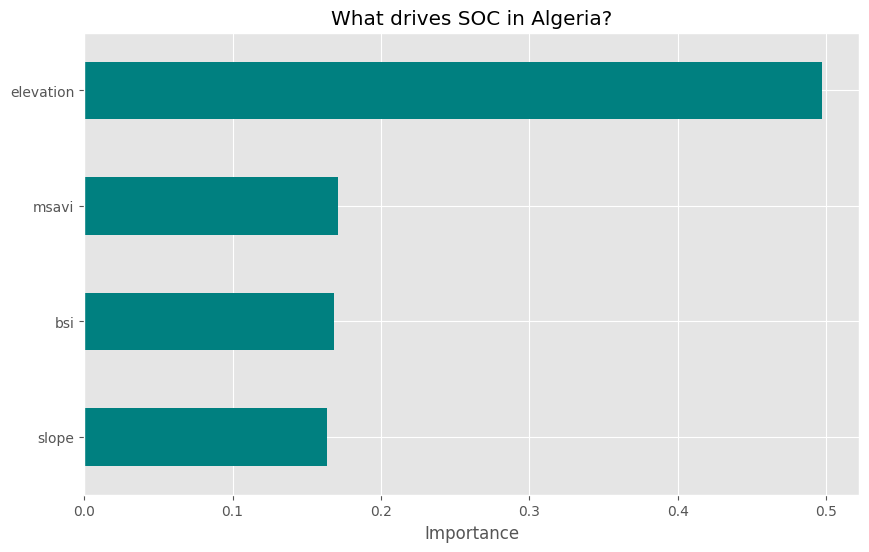

In [62]:
# Split into Train and Validation sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Train the Model
rf_model.fit(X_train, y_train)

# Validate
predictions = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print(f"Model Performance:")
print(f"RMSE: {rmse:.2f} (Mg C/ha)")
print(f"R-Squared: {r2:.2f}")

# Feature Importance Plot
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', color='teal')
plt.title("What drives SOC in Algeria?")
plt.xlabel("Importance")
plt.show()

**7. Operational Mapping & Uncertainty**

We will now apply our trained "brain" (the model) to the entire study area (all pixels, not just the training ones).
To quantify confidence, we will run a small **Ensemble**: we predict 10 times, and check where the predictions agree (stable) or disagree (uncertain).

In [64]:
# Prepare the full input data for prediction
# We need to drop the 'soc' column and coordinate columns
full_input = df[["msavi", "bsi", "elevation", "slope"]]

# --- ENSEMBLE PREDICTION ---
n_iterations = 10
all_predictions = []

print("Running Ensemble Prediction Loop...")
for i in range(n_iterations):
    # Train a fresh model with a different random seed
    model = RandomForestRegressor(n_estimators=25, random_state=i, n_jobs=-1)
    model.fit(X_train, y_train)

    # Predict on the FULL area
    pred = model.predict(full_input)
    all_predictions.append(pred)

# Convert list of arrays to numpy array
all_predictions = np.array(all_predictions) # Shape: (10, num_pixels)

# Calculate Mean (The Final Map) and STD (The Uncertainty Map)
mean_pred = np.mean(all_predictions, axis=0)
std_pred = np.std(all_predictions, axis=0)

# Put back into the dataframe to reconstruct the map
df["soc_predicted_mean"] = mean_pred
df["soc_uncertainty"] = std_pred

# Convert DataFrame back to Xarray for plotting
final_ds = df.set_index(["y", "x"]).to_xarray()


Running Ensemble Prediction Loop...


**8. Visualisation finale**

Let's look at our result.

**Left:** Our new, high-resolution (30m) SOC map.

**Right:** Where is the model confused? (Uncertainty).

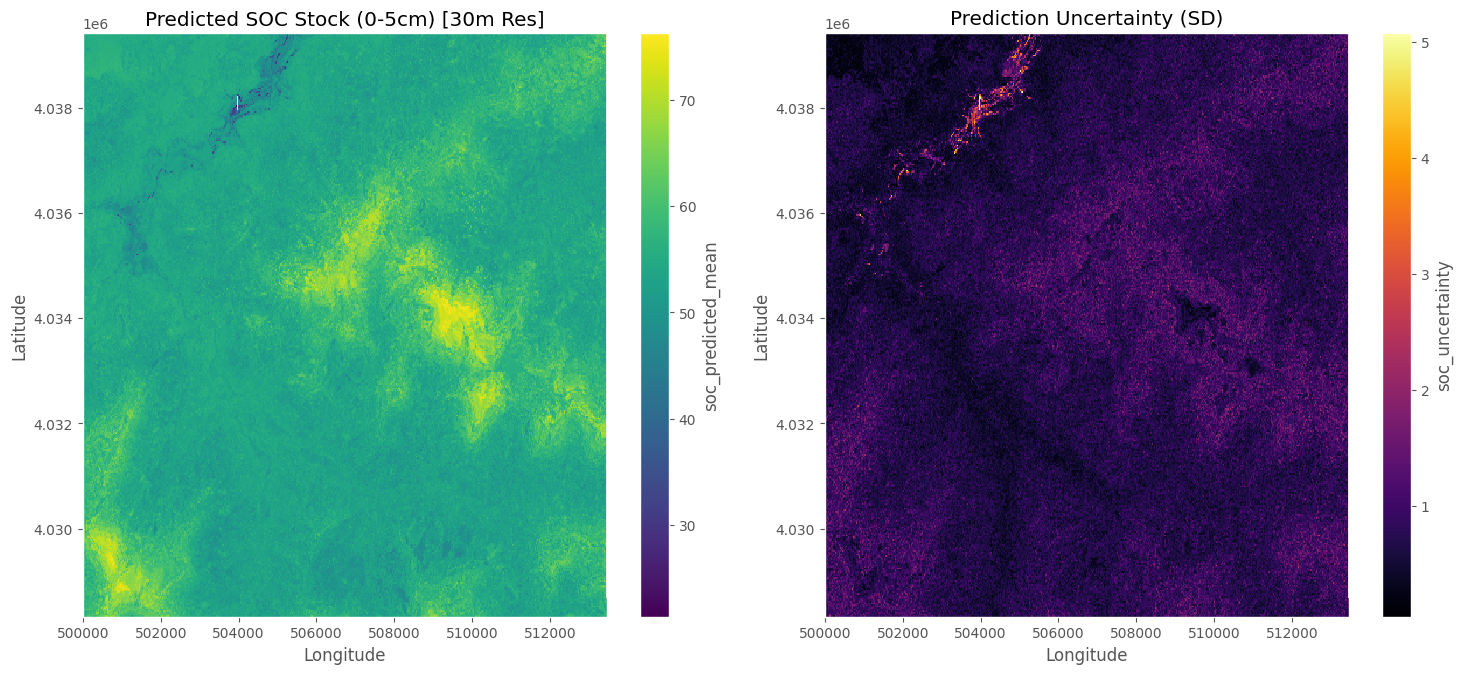

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Plot Mean Prediction
final_ds["soc_predicted_mean"].plot(ax=ax1, cmap="viridis")
ax1.set_title("Predicted SOC Stock (0-5cm) [30m Res]")
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")

# Plot Uncertainty (Standard Deviation)
final_ds["soc_uncertainty"].plot(ax=ax2, cmap="inferno")
ax2.set_title("Prediction Uncertainty (SD)")
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")

plt.tight_layout()
plt.show()


**Question de discussion :**
Look at the Uncertainty Map. Do you see higher uncertainty in the mountains (high slope) or in the flat agricultural plains? Why might the model struggle in those areas?